<a href="https://colab.research.google.com/github/atlanticstarr1/mnist/blob/main/mnist_resnet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# REFERENCES (REALLY GOOD)
# https://keras.io/examples/vision/consistency_training/
# https://github.com/keras-team/keras-io/blob/master/examples/vision/adamatch.py
# https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/adamatch.ipynb

In [52]:
# %pip install --upgrade tensorflow
# %pip install tensorboard
# %pip install keras-cv
# %pip install tensorflow-addons
# %pip install scikit-plot
# %pip install tf-models-official

In [53]:
%matplotlib inline
import keras_cv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from keras import layers
#from keras_cv.layers import RandAugment
from keras.optimizers import Adam,RMSprop,SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler,TensorBoard
from keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,classification_report, confusion_matrix
from official.vision.ops import augment
import math
from lr_find import LrFinder
from one_cycle import OneCycleLr

tfds.disable_progress_bar()
tf.random.set_seed(42)

In [54]:
# Load dataset
(train_set, valid_set, test_set) ,info= tfds.load("mnist", split=["train[:90%]", "train[90%:]", "test"],as_supervised=True, with_info=True)
# Extract informative features
class_names = info.features["label"].names
num_classes = info.features["label"].num_classes

In [55]:
## Define constants and hyperparameters
RESIZE_TO = 32
INPUT_SHAPE = 3
BATCH_SIZE = 512
EPOCHS = 60
TRAIN_SIZE = len(train_set)
AUTO = tf.data.AUTOTUNE
STEPS_PER_EPOCH =math.ceil(TRAIN_SIZE / BATCH_SIZE)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
MIN_LR = 1e-4
MAX_LR = 2e-3

In [56]:
# logs
%reload_ext tensorboard
log_folder = 'logs'

In [57]:
# Initialize `RandAugment`
# augmenter =keras_cv.layers.RandAugment(
#     value_range=(0, 255),
#     augmentations_per_image=3,
#     magnitude=0.9,
#     magnitude_stddev=0.2,
#     rate=0.5,
# )

In [58]:
# original_exclude_list= [
#     'AutoContrast', 'Equalize', 'Invert', 'Posterize', 'Solarize','Rotate',
#     'Color', 'Contrast', 'Brightness', 'Sharpness', 'ShearX', 'ShearY',
#     'TranslateX', 'TranslateY', 'Cutout', 'SolarizeAdd']
exclude_list= ['Equalize', 'Invert','Contrast', 'Posterize', 'Solarize','Color', 'Cutout', 'SolarizeAdd','Brightness','ShearX','ShearY','Sharpness','AutoContrast','TranslateX','TranslateY']
# augmenter = augment.RandAugment(exclude_ops=exclude_list)
augmenter = augment.image_ops.RandomRotation(0.1)
trainAug = tf.keras.Sequential([
    augment.image_ops.RandomRotation(0.1),
    augment.image_ops.RandomTranslation(0.1,0.1),
    augment.image_ops.RandomZoom(0.1,0.1)
])

In [59]:
# layers = keras_cv.layers.RandAugment.get_standard_policy(
#     value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
# )

# layers = [
#     layer for layer in layers if not isinstance(layer, (keras_cv.layers.Equalization,keras_cv.layers.RandomColorDegeneration))
# ]

# pipeline =keras_cv.layers.RandomAugmentationPipeline(
#     layers=layers, augmentations_per_image=3
# )

In [60]:
# rand_aug = iaa.RandAugment(n=3, m=7)

# def augment(images):
#     # Input to `augment()` is a TensorFlow tensor which
#     # is not supported by `imgaug`. This is why we first
#     # convert it to its `numpy` variant.
#     images = tf.cast(images, tf.uint8)
#     return rand_aug(images=images.numpy())

In [61]:
# def tf_cv2_func(image, label):
#     [image] = tf.py_function(pipeline, [image], [tf.float32])
#     return image, label

In [62]:
def resize_and_rescale(image, label):
    # convert MNIST images to RGB
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
    #image = tf.tile(image, [1, 1, 3])
    #image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return image,label

def prepare_dataset(dataset, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    dataset = dataset.map(resize_and_rescale, num_parallel_calls=AUTO)
    if shuffle:
        dataset = dataset.shuffle(TRAIN_SIZE,seed=42)
     # Batch all datasets.
    dataset = dataset.batch(BATCH_SIZE)
     # Use data augmentation only on the training set.
    if augment:
        #dataset = dataset.map(lambda x,y:(augmenter(x),y),num_parallel_calls=AUTO)
        dataset = dataset.map(lambda x,y:(augmenter(x),y),num_parallel_calls=AUTO)
        #dataset = dataset.map(lambda x,y:(trainAug(x,training=True),y),num_parallel_calls=AUTO)
    # Use buffered prefetching on all datasets.
    return dataset.prefetch(AUTO)

Generate datasets

In [63]:
# setup datasets
train_dataset = prepare_dataset(train_set,shuffle=True)
train_dataset_aug = prepare_dataset(train_set,shuffle=True,augment=True)
val_dataset = prepare_dataset(valid_set)
test_dataset = prepare_dataset(test_set)

Inspect some samples from our dataset

In [64]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for images,labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
    plt.show()

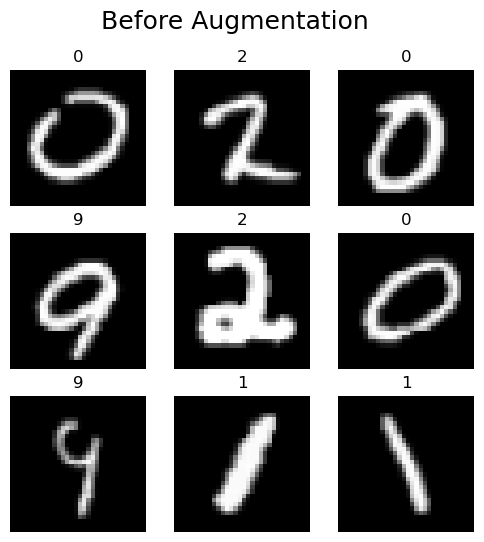

In [65]:
visualize_dataset(train_dataset, title="Before Augmentation")

In [66]:
#train_dataset_aug.save("./augment")

In [67]:
#new_dataset_aug = tf.data.Dataset.load("./augment")

In [68]:
# get total elements
# total = []
# for element in new_dataset_aug.as_numpy_iterator(): 
#   total.append(element[1])

# all_total = np.concatenate(total)
# print(len(all_total))

In [69]:
#visualize_dataset(new_dataset_aug, "augmented from disk")

Visualize after RandAugment

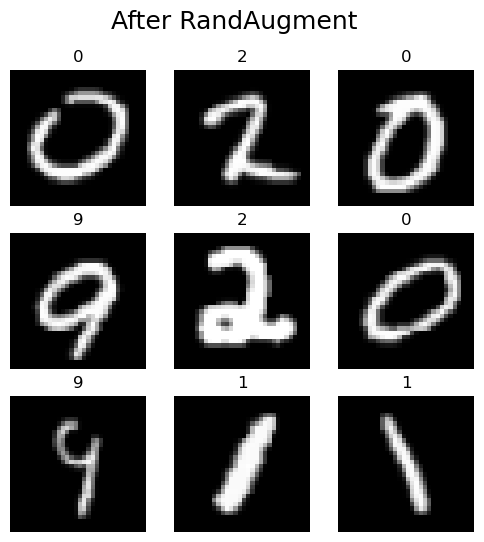

In [70]:
visualize_dataset(train_dataset_aug, title="After RandAugment")

In [71]:
# Define a model building utility function (ResNet50V2 architecture)
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(RESIZE_TO, RESIZE_TO, INPUT_SHAPE)
    )
    model = tf.keras.Sequential(
        [
            keras.layers.Input((RESIZE_TO, RESIZE_TO, INPUT_SHAPE)),
            keras.layers.Rescaling(scale=1.0 / 255.0),
            resnet50_v2,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(num_classes),
        ]
    )
    return model

In [72]:
def train_model(model, optimizer,train_data=train_dataset):
    callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath='final_model_weights.h5',save_weights_only=True,save_best_only=True)
    ]

    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    history = model.fit(
        train_data,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [73]:
# Get model
my_model = get_training_model()
my_model.save_weights("initial_model_weights.h5")

Finding best initial lr over 106 steps


  0%|          | 0/106 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
Min numerical gradient (min_lr): 1.68E-03
Min loss divided by 10 (max_lr): 2.28E-03


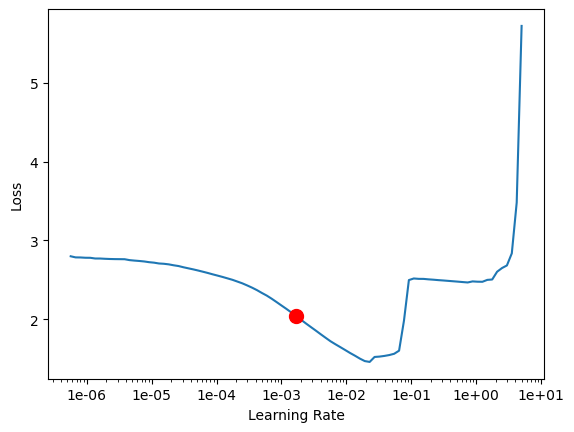

In [74]:
# Instantiate LrFinder
optimizer = Adam()
loss_fn = CategoricalCrossentropy(from_logits=True)
lr_find = LrFinder(my_model, optimizer, loss_fn)
lr_find.range_test(train_dataset,num_iter=STEPS_PER_EPOCH)
lr_find.plot_lrs(skip_end=0,suggestion=True)

In [75]:
# get optimal learning rates
min, min_idx = lr_find.minimum() # ideally the optimal learning rate but may cause divergence. smallest learning rate
#max_lr = (min/10.0) if min*100.0<=10.0 else (min/100.0) # the recommended maximum learning rate is much less than the learning rate at which the loss is the smallest. optimal learning rate.
max_lr = (min/10.0)
min_lr, steep_idx = lr_find.steep() # the baseline/ lowest learning rate is the value at which the loss reduces the fastest (minimal negative gradient) - steepest point.
#min_lr = min_lr if (max_lr/min_lr)>=4.0 else 0.001
valley, valley_idx = lr_find.valley()
slide, slide_idx = lr_find.slide() #try adjusted values: 0.5,0.01,0.05 or try increasing lr_diff to bigger values

# https://forums.fast.ai/t/new-lr-finder-output/89236/2
# Valley > Slide > Steep > Minimum

In [76]:
# show possible learning rates
print("max_lr:", max_lr)    #optimal learning rate
print("min_lr:", min_lr)    #min learning rate
print("valley:", valley)
print("slide:", slide)
print("min_grad:", min)
print("min loss:", min_idx)

max_lr: 0.0022829193621873856
min_lr: 0.0016842831
valley: 6.200873e-05
slide: 0.0008404817781411111
min_grad: 0.022829194
min loss: 1.4565955


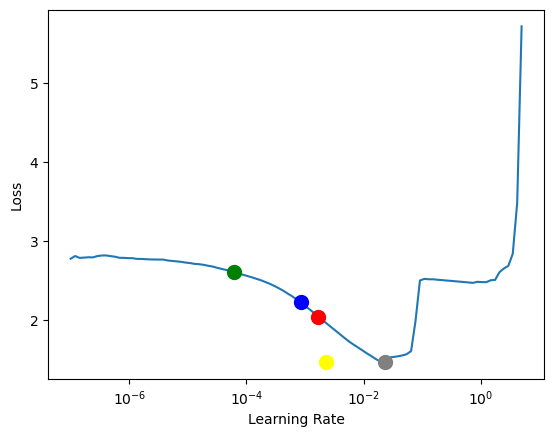

In [77]:
# plot optimal learning rates
_, ax = plt.subplots(1, 1)
ax.plot(lr_find.lrs, lr_find.losses)
ax.plot(max_lr, min_idx,markersize=10,marker="o", color="yellow")  # max_lr
ax.plot(min_lr, steep_idx, markersize=10,marker="o", color="red") # min_lr
ax.plot(valley, valley_idx, markersize=10,marker="o", color="green") #valley
ax.plot(slide,slide_idx,markersize=10,marker="o", color="blue")  #slide
ax.plot(min,min_idx,markersize=10,marker="o", color="gray")  #min loss
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale("log")

In [93]:
one_c = OneCycleLr(max_lr=0.001, total_steps=TOTAL_STEPS)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
    maximal_learning_rate=2.38e-3,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=4* STEPS_PER_EPOCH
)
optimizer = tf.keras.optimizers.Adam(clr)

callbacks = [
    one_c,
    tf.keras.callbacks.TerminateOnNaN(),
    #ReduceLROnPlateau(patience=3, factor=0.5),
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath='final_model_weights.h5',save_weights_only=True,save_best_only=True)
    ]
my_model=get_training_model()
my_model.load_weights("initial_model_weights.h5")
my_model.compile(
    optimizer=Adam(),
    #optimizer=optimizer,
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

start = time.perf_counter()
history = my_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)
duration = time.perf_counter()-start
hrs=int(duration/3600)
mins=int((duration-hrs*3600)/60)
secs= duration-hrs*3600-mins*60
msg='The training cycle took {0} hours {1} minutes and{2:6.2f} seconds'
print(msg.format(hrs, mins,secs))

Epoch 1/60
  6/106 [>.............................] - ETA: 15s - loss: 2.5243 - accuracy: 0.1491WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0686s vs `on_train_batch_end` time: 0.0844s). Check your callbacks.


106/106 [==============================] - 23s 167ms/step - loss: 1.2401 - accuracy: 0.6099 - val_loss: 2.0132 - val_accuracy: 0.2662
Epoch 2/60
106/106 [==============================] - 17s 159ms/step - loss: 0.1587 - accuracy: 0.9550 - val_loss: 1.6084 - val_accuracy: 0.4967
Epoch 3/60
106/106 [==============================] - 17s 159ms/step - loss: 0.0497 - accuracy: 0.9853 - val_loss: 1.0854 - val_accuracy: 0.6605
Epoch 4/60
106/106 [==============================] - 18s 160ms/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 0.7459 - val_accuracy: 0.7812
Epoch 5/60
106/106 [==============================] - 18s 160ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.4351 - val_accuracy: 0.8710
Epoch 6/60
106/106 [==============================] - 18s 160ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 0.1593 - val_accuracy: 0.9588
Epoch 7/60
106/106 [==============================] - 18s 163ms/step - loss: 0.0211 - accuracy: 0.9939 - val_loss: 0.0654 - val_accuracy: 0.9

In [79]:
# to plot the learning_rate & momentum(or beta_1) graphs
#one_c.plot_lrs_moms()

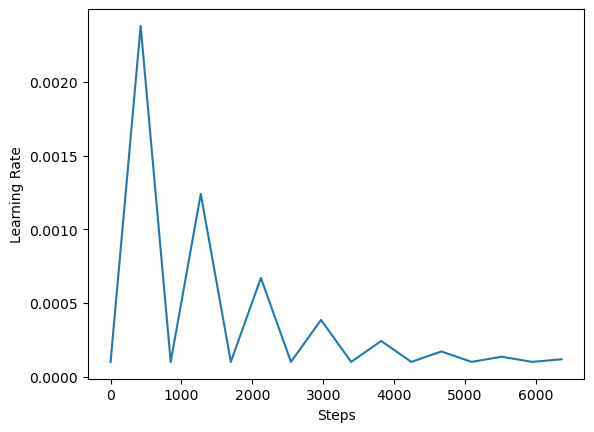

In [80]:
step = np.arange(0, EPOCHS * STEPS_PER_EPOCH)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

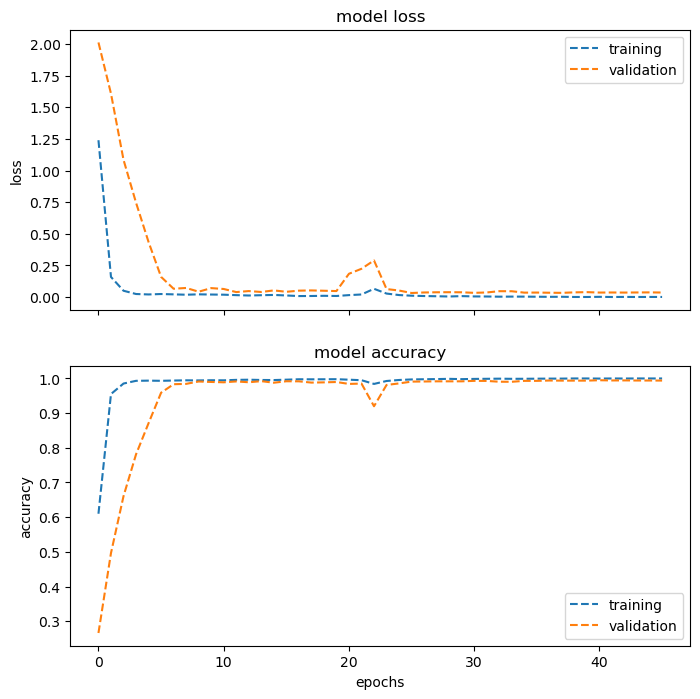

In [94]:
# plot loss during training
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(8,8))
ax1.set_title("model loss")
ax1.plot(history.history['loss'],'--')
ax1.plot(history.history['val_loss'],'--')
ax1.legend(['training', 'validation'],loc='best')
ax1.set_ylabel('loss')
# plot accuracy during training
ax2.set_title("model accuracy")
ax2.plot(history.history['accuracy'],'--')
ax2.plot(history.history['val_accuracy'],'--')
ax2.legend(['training', 'validation'], loc='best')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
plt.show()

In [95]:
# Evaluate the teacher model on the test set.
_,acc = my_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 99.33%


In [83]:
# Generate predictions
y_pred = my_model.predict(test_dataset,verbose=0)
y_pred = y_pred.argmax(axis=1) # predicted labels
y_true = np.concatenate([y for x,y in test_dataset]).argmax(axis=1) # true labels

In [84]:
# Evaluate predictions
acc = accuracy_score(y_true, y_pred)
precision =precision_score(y_true,y_pred,average="macro")
recall =recall_score(y_true,y_pred,average="macro")
f1score =f1_score(y_true,y_pred,average="macro")
print("Accuracy = %4.4f" %acc)
print("Precision = %4.4f" %precision)
print("Recall = %4.4f" %recall)
print("F1-score = %4.4f" %f1score)

Accuracy = 0.9939
Precision = 0.9939
Recall = 0.9938
F1-score = 0.9938


In [85]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9969    0.9980    0.9975       980
           1     0.9965    0.9982    0.9974      1135
           2     0.9952    0.9971    0.9961      1032
           3     0.9844    0.9990    0.9916      1010
           4     0.9879    0.9959    0.9919       982
           5     0.9966    0.9888    0.9927       892
           6     0.9958    0.9916    0.9937       958
           7     0.9951    0.9942    0.9946      1028
           8     0.9959    0.9938    0.9949       974
           9     0.9950    0.9812    0.9880      1009

    accuracy                         0.9939     10000
   macro avg     0.9939    0.9938    0.9938     10000
weighted avg     0.9939    0.9939    0.9939     10000



In [86]:
pd.DataFrame(confusion_matrix(y_true, y_pred))

,0,1,2,3,4,5,6,7,8,9
0,978,0,1,0,0,0,0,1,0,0
1,0,1133,0,0,0,0,2,0,0,0
2,0,1,1029,1,0,0,0,1,0,0
3,0,0,0,1009,0,1,0,0,0,0
4,0,0,1,0,978,0,2,0,0,1
5,0,0,0,8,0,882,0,0,1,1
6,3,1,0,0,0,1,950,0,3,0
7,0,2,2,0,0,0,0,1022,0,2
8,0,0,0,4,0,1,0,0,968,1
9,0,0,1,3,12,0,0,3,0,990


In [87]:
model = get_training_model()
model.load_weights('final_model_weights.h5')
model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.evaluate(test_dataset)

20/20 [==============================] - 2s 44ms/step - loss: 0.0254 - accuracy: 0.9939


[0.02535232901573181, 0.9939000010490417]